# Speech Emotion Recognition
# Procesor semnal asociat cu date vocale pentru detectia starii emotionale 

## Introduction  - eventual un rezumat in limba romana 
This notebook explores the development of a speech emotion recognition (SER) model using Reaction-Diffusion Convolutional Neural Networks (RD-CNN) and RDT-enhanced spectral features. Unlike traditional approaches that rely on sequential models like LSTM, we focus on spectrogram-based classification using Mel spectrograms and applying the Reaction-Diffusion Transform (RDT) to highlight key spectral characteristics.

Our goal is to balance classification accuracy and computational efficiency, making the model suitable for real-time Android deployment. We focus on 8 emotions: 'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral' , 'Sad', 'Surprise' , 'Calm'.

The dataset combines RAVDESS, TESS, and SAVEE, followed by preprocessing, RDT filtering, and data augmentation to improve robustness. We compare the performance of Mel spectrograms vs. RDT-enhanced spectrograms and optimize the final model through TensorFlow Lite (TFLite) conversion for efficient deployment on Android devices.
Resources:
https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
https://github.com/radu-dogaru/vres-cnn ,
cod din l1_ici_char_recogn.ipynb, emospeech_rdt_18mar25.ipynb


## 0 Importing Libraries
Include the necessary libraries for data manipulation, visualization, and model building:

In [70]:
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout,Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 1 Dataset
We will use three different datasets for speech emotion recognition: RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song), TESS (Toronto Emotional Speech Set), and SAVEE (Surrey Audio-Visual Expressed Emotion). These datasets offer several benefits that contribute to the development of more robust and accurate SER models:

1. Variety of emotional expressions:<br> These datasets encompass a wide range of emotions, such as happy, sad, angry, fearful, surprised, disgusted, and neutral. This variety helps train models to recognize and distinguish subtle differences between various emotional expressions, enhancing their performance.

2. Multiple speakers:<br> Including multiple speakers with different accents, genders, and speaking styles provide a more diverse and representative speech data sample. This diversity helps models generalize to real-world scenarios, making them more effective in handling speech data from various sources.

3. High-quality recordings:<br> The audio files in these datasets are recorded with high-quality equipment, resulting in clear and consistent audio samples, allowing models to focus on the emotional content of the speech without being hindered by noise or other artifacts.

In [71]:
#cai baze de date in forma bruta
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

## 2 Data Exploration
In this section, you've plotted waveforms and spectrograms for emotions data.

In [72]:
#DEFINIRE FUNCTII PENTRU CREARE BAZA DE DATE
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funcție pentru extragerea datelor dintr-un director

#sugestie pastreaza doar audio-ul si etichetele, uitate-te la codul trimis de prof emospeech-rdt
def process_dataset(directory, filename_parser):
    """
    Procesează un dataset audio, transformând fișierele în spectrograme și etichete.
    """
    file_emotion = []
    file_path = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            current_path = os.path.join(root, file)
            emotion = filename_parser(file)

            if emotion is not None:
                #file_path.append(Ravdess + dir + '/' + file) in caz ca nu ruleaza foloseste asta
                file_path.append(current_path)
                file_emotion.append(emotion)

    return np.array(file_path), np.array(file_emotion)

# Parsarea fișierelor pentru RAVDESS
def parse_ravdess_filename(filename):
    try:
        part = filename.split('-')[2]  # A treia componentă din nume reprezintă emoția
        return int(part)
    except:
        return None

# Parsarea fișierelor pentru TESS
def parse_tess_filename(filename):
    part = filename.split('_')[2].split('.')[0]
    return 'surprise' if part == 'ps' else part

# Parsarea fișierelor pentru SAVEE
def parse_savee_filename(filename):
    part = filename.split('_')[1][:-6]  # Extragerea etichetei
    mapping = {'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 
               'n': 'neutral', 'sa': 'sad', 'su': 'surprise'}
    return mapping.get(part, None)


# 2.1. parsare si concatenare 
! nu sunt datele propriu-zise ci adresele fisierelor .wav asociate diverselor etichete 


procesare date ravdess:  0.54 sec
procesare date tess:  4.06 sec
procesare date savee:  0.81 sec
   Emotions                                               Path
0  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
1     angry  /kaggle/input/toronto-emotional-speech-set-tes...
2     happy  /kaggle/input/ravdess-emotional-speech-audio/a...
3       sad  /kaggle/input/toronto-emotional-speech-set-tes...
4   disgust  /kaggle/input/toronto-emotional-speech-set-tes...


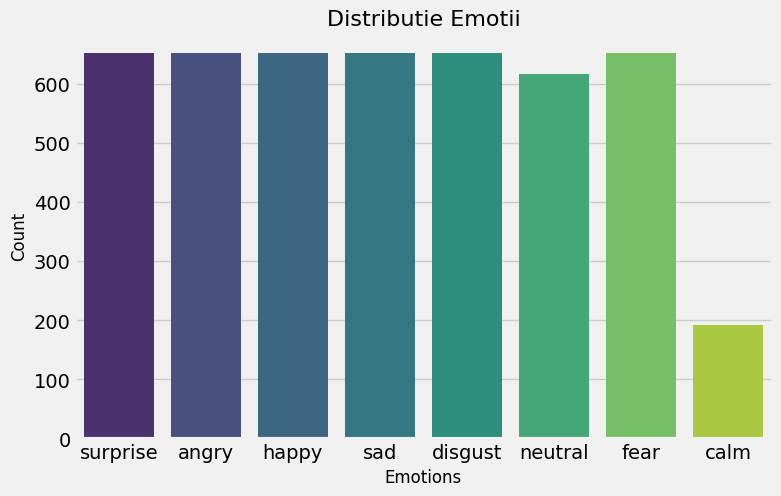

In [73]:
#REALIZARE BAZA DE DATE IN FORMAT TENSOR
import time as ti 
# Procesare dataset-uri
t1=ti.time()
X_ravdess, y_ravdess = process_dataset(Ravdess, parse_ravdess_filename)
t2=ti.time(); print('procesare date ravdess: ',round(t2-t1,2), 'sec')
X_tess, y_tess = process_dataset(Tess, parse_tess_filename)
t3=ti.time(); print('procesare date tess: ',round(t3-t2,2), 'sec')
X_savee, y_savee = process_dataset(Savee, parse_savee_filename)
t4=ti.time(); print('procesare date savee: ',round(t4-t3,2), 'sec')

# Convertim etichetele RAVDESS în text
emotion_mapping = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
y_ravdess = np.array([emotion_mapping[e] for e in y_ravdess])

# Concatenăm toate datele
X = np.concatenate([X_ravdess, X_tess, X_savee])
y = np.concatenate([y_ravdess, y_tess, y_savee])


# Creare dataframe pentru analiză
#creeeaza coloana de path-uri, fa-le concatenarea, in codul profului fix inainte de Pregatire date agregata ...(am incercat)
data_df = pd.DataFrame({'Emotions': y,'Path': X})
data_df = data_df.sample(frac=1).reset_index(drop=True)  # Amestecare aleatorie

#Posibil suplimentar
# Eliminăm emoțiile 'fear' și 'disgust'
#data_df = data_df[~data_df['Emotions'].isin(['fear', 'disgust'])]

# Reducem 'sad' și 'angry' și le grupăm ca 'unpleasant'
#data_df = data_df.drop(data_df[data_df['Emotions'] == 'sad'].sample(frac=0.4).index)
#data_df = data_df.drop(data_df[data_df['Emotions'] == 'angry'].sample(frac=0.4).index)
#data_df['Emotions'] = data_df['Emotions'].replace(['sad', 'angry'], 'unpleasant')
# Salvare CSV pentru utilizare ulterioară
data_df.to_csv("data_path.csv", index=False)

print(data_df.head())
# Vizualizare distribuție emoții
plt.figure(figsize=(8, 5))
plt.title('Distributie Emotii', size=16)
sns.countplot(data=data_df, x='Emotions', palette='viridis')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Functii de baza pentru generare spectrograme dupa metoda NRDT 
Adaptat dupa:
https://github.com/radu-dogaru/NL-CNN-RDT-based-sound-classification-
Radu Dogaru and Ioana Dogaru "RD-CNN: A Compact and Efficient Convolutional Neural Net for Sound Classification ", ISETC-2020 

In [74]:
# functia de baza  (echivalent spectrograma MEL) - celula se ruleaza doar o data 
# 
def NRDT(signal, w, flag, channels):
    #signal = signal.astype('float32') 
    Nsamples = np.shape(signal)[1] # Numarul total de sample-uri ale fisierului.
    
    
    #signal =np.reshape(signal.T,(1,Nsamples))
    # aici mici modificari pentru semnal in format (N,) daca se testeaza independent
    
    delmax = int(0.45*w) # Delay-urile nu trebuie sa fie mai mari ca w/4
    res = np.where(channels<=delmax) # Alegem canalele unde este indeplinita conditia de mai sus.
    #print(res)
    channels = channels[res]  # Canalele care nu respecta conditia sa aiba lungimea mai mica ca w/4 sunt ignorate.
    m = np.shape(channels)[0] # Numarul de canale ramase.
    
    spectrograms = Nsamples//w # Numarul de spectrograme calculate 
    Samples = spectrograms*w # Numarul de sample-uri utilizate pentru a calcula o spectrograma. Cele care au mai ramas nu se mai folosesc.
    matrix = np.reshape(signal[0,0:Samples],(spectrograms,w)) # Pe fiecare linie se va calcula o spectrograma. 
    # Valorile vectorului semnalului se depun intr-o matrice de dimensiune Nsamples//w (spectrograms) * w.
    
    spectrum = np.zeros((m,spectrograms)) # Initializarea spectrogramei cu valori de 0.
    # Nr de linii = nr. de canale care respecta conditia channels < delmax.
    # Nr de coloane = nr. de spectrograme (Nsamples//w).
    for i in range(0,spectrograms): 
        values = matrix[i,:] # Toata linia 
        # Ia cate o linie din matrice, care contine datele semnalului signal 
        for k in range(0,m): # k-ul parcurge canalele care respecta conditia sa fie < decat delmax
            delay=channels[k]  # Se atribuie cate un delay din vectorul de delay-uri channels. 
            latest=0 # normal 0 
            t=np.array(range(delay,w-delay-1-latest))
            # Directional difusion t+delay+1 
            difus=np.abs(values[t-delay]+values[t+latest+delay]-2*values[t]) # Se calculeaza o valoare din matricea spectrului 
            # Fiecare canal va calcula pentru fiecare linie din matrice o valoare din spectru.
            if flag==0:
                spectrum[k,i]=np.mean(difus)/4
            elif flag==1:
                spectrum[k,i]=np.mean(difus/(np.abs(values[t-delay])+np.abs(values[t+delay])+2*np.abs(values[t])+1e-12))/4
    return spectrum 


def get_features_nrdt_(signal, M, w, flag, prag, chan):
  # cu intrarea signal in format "flatten"
  signal=np.reshape(signal,(1,np.shape(signal)[0]))
  signal = signal.astype('float32')
  delmax=int(0.45*w)
  res = np.where(chan<=delmax)
  channels = chan[res]
  m = np.shape(chan)[0]
  res = np.where(np.abs(signal)>=prag)
  semnal = signal[0,res[1]]
  semnal = np.reshape(semnal.T,(1,np.shape(semnal)[0]))
  Feat_spec = np.zeros((M,m))

  Npsgm = np.shape(semnal)[1]//M
  #print('Nr_es_per_segm=',Npsgm, 'Ferestre pe segment: ', Npsgm // w)

  for isgm in range(0,M):
    ssegment = np.reshape(semnal[0,isgm*Npsgm:(isgm+1)*Npsgm],(1,Npsgm))
    #print('isegm: ', isgm, 'ssegment shape: ',np.shape(ssegment))
    spectrum = NRDT(ssegment, w, flag, chan)
    mediumRDT = sum(np.transpose(spectrum))
    #print('medrdt_shape: ',np.shape(mediumRDT))
    #print(type(mediumRDT)) # Tipul e recunoscut ca int in loc de ndarray ??
    #Features[isgm*m:(isgm+1)*m] = mediumRDT
    Feat_spec[isgm,:] = mediumRDT.T
  ferestre=Npsgm // w
  return ferestre, Feat_spec
    

# 3.0 - Preprocesare 

Processing Data: 0/4720
Numar minim ferestre:  16 Numar maxim ferestre:  16
Processing Data: 100/4720
Numar minim ferestre:  10 Numar maxim ferestre:  36
Processing Data: 200/4720
Numar minim ferestre:  12 Numar maxim ferestre:  52
Processing Data: 300/4720
Numar minim ferestre:  11 Numar maxim ferestre:  48
Processing Data: 400/4720
Numar minim ferestre:  11 Numar maxim ferestre:  38
Processing Data: 500/4720
Numar minim ferestre:  9 Numar maxim ferestre:  48
Processing Data: 600/4720
Numar minim ferestre:  10 Numar maxim ferestre:  51
Processing Data: 700/4720
Numar minim ferestre:  11 Numar maxim ferestre:  51
Processing Data: 800/4720
Numar minim ferestre:  11 Numar maxim ferestre:  42
Processing Data: 900/4720
Numar minim ferestre:  9 Numar maxim ferestre:  46
Processing Data: 1000/4720
Numar minim ferestre:  10 Numar maxim ferestre:  48
Processing Data: 1100/4720
Numar minim ferestre:  10 Numar maxim ferestre:  46
Processing Data: 1200/4720
Numar minim ferestre:  10 Numar maxim f

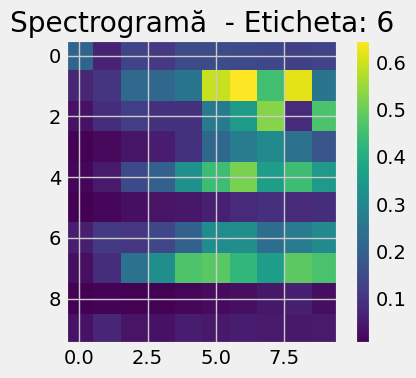

In [75]:
#E SUPER IMPORTANTA!!! adaptata dupa codul de la curs
#GENERARE DATASET CU FFT (NU RDT)
#GENERARE SPECTOGRAME FFT+ NRDT
import cv2
import time as ti
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

# Încărcarea dataset-ului cu etichete corecte
aggregated_data = pd.read_csv("data_path.csv")
labels = {'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, 'disgust':7, 'surprise':8}
aggregated_data.replace({'Emotions': labels}, inplace=True)

# Parametrii generali
SAMPLE_RATE = 22050 
M = 10
w = 256
prag = 0.0001
flag = 0  
typ_trafo = 'NRDT'  # FFT, nu RDT
generate_channels = np.array([1,2,4,5,8,16,20,32,64,96])
SAMPLE_NUM = aggregated_data.shape[0]
CROP = False

fft_params = (M, w, prag, flag, generate_channels)

# Inițializare dataset
data = {
    "labels": [],
    "features": []
}

# Funcție pentru generarea spectrogramelor FFT
# ieșire 32x32, normalizată între 0-1
def compute_fft_spectrogram(signal, sr, segment_size=2048, step_size=512):
    segments = [signal[i : i + segment_size] for i in range(0, len(signal) - segment_size, step_size)]
    spectrogram = np.array([np.fft.fft(seg) for seg in segments])
    spectrogram = np.abs(spectrogram[:, : segment_size // 2])
    spectrogram_resized = cv2.resize(spectrogram, (32, 32))

    min_val = np.min(spectrogram_resized)
    max_val = np.max(spectrogram_resized)
    if max_val - min_val == 0:
        spectrogram_resized = np.zeros_like(spectrogram_resized)
    else:
        spectrogram_resized = (spectrogram_resized - min_val) / (max_val - min_val)
    return spectrogram_resized

# Generare spectrograme FFT / NRDT pentru toate fișierele
fermin = 1000000
fermax = 0
t1 = ti.time()
for i in range(SAMPLE_NUM):
    data['labels'].append(aggregated_data.iloc[i, 0])
    signal, sample_rate = librosa.load(aggregated_data.iloc[i, 1], sr=SAMPLE_RATE)
    if CROP:
        start_time = 0.4
        end_time = 1.9
        start_frame = int(start_time * sample_rate)
        end_frame = int(end_time * sample_rate)
        signal = signal[start_frame:end_frame]

    if typ_trafo == 'ALTA':
        fft_spectrogram = compute_fft_spectrogram(signal, sample_rate)
        data["features"].append(np.array(fft_spectrogram))
        fer = 3
    elif typ_trafo == 'NRDT':
        (fer, feat2d) = get_features_nrdt_(signal, M, w, flag, prag, generate_channels)
       # print(f" NRDT shape: {np.array(feat2d).shape}")
        data["features"].append(np.array(feat2d))

    if fer < fermin:
        fermin = fer
    if fer > fermax:
        fermax = fer
    if i % 100 == 0:
        print(f'Processing Data: {i}/{SAMPLE_NUM}')
        print('Numar minim ferestre: ', fermin, 'Numar maxim ferestre: ', fermax)
        fermin = 1000000
        fermax = 0
t2 = ti.time()
print('Proces extragere trasaturi finalizat dupa ', t2 - t1, 'secunde')

# Conversie la numpy
X = np.array(data['features'])
y = np.array(data['labels'])

# Împărțirea dataset-ului în train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

y_train -= 1
y_test -= 1
num_classes = len(np.unique(y_train))

# Redimensionare pentru CNN
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print(f'Training Data: {X_train.shape} with label {y_train.shape}')
print(f'Testing Data: {X_test.shape} with label {y_test.shape}')

input_shape = (np.shape(X_train)[1], np.shape(X_train)[2], 1)
num_classes = 1 + np.max(y_train)

print('Input shape: ', input_shape)
print('Num classes: ', num_classes)



#pune vizualizare spectograma
# Vizualizare spectrogramă exemplu FFT sau NRDT
plt.figure(figsize=(4, 4))
plt.imshow(X_train[0].squeeze(), cmap='viridis' , aspect='auto')
plt.title(f"Spectrogramă  - Eticheta: {y_train[0]}")
plt.colorbar()
plt.tight_layout()
plt.show()


# 3.2. - verifica daca exista nAn - in caz afirmativ se ajusteaza M sau w  astfel numar min ferestre sa fie >1

In [76]:
#Verificare daca exista NaN in date
print("NaNs în X_train:", np.isnan(X_train).sum())
print("NaNs în X_test:", np.isnan(X_test).sum())
print(f" Dimensiuni corecte: X_train={X_train.shape}, y_train={y_train.shape}, classes={num_classes}")

NaNs în X_train: 0
NaNs în X_test: 0
 Dimensiuni corecte: X_train=(3776, 10, 10, 1), y_train=(3776,), classes=8


3.3 Salvare date in format tensor


In [77]:
from scipy.io import savemat

nume_set = 'RDT1.mat'

# Dicționarul de date
data_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

# Doar dacă folosim NRDT și toate componentele sunt valide
if typ_trafo == 'NRDT' and all(v is not None for v in [M, w, prag, flag]) and generate_channels is not None:
    rdt_params = {
        'M': M,
        'w': w,
        'prag': prag,
        'flag': flag,
        'channels': generate_channels
    }
    data_dict['rdt_params'] = rdt_params

# Salvare efectivă
savemat(nume_set, data_dict)
print(" Datele au fost salvate în format .mat!")



 Datele au fost salvate în format .mat!


In [78]:
#CELULA DE CITIRE DATE - inspiratie L4

from scipy.io import loadmat
# teste incarcare dataset - de ex. in L4 se va adauga o celula cu 
# continutul de mai jos: 
dataset='/kaggle/working/RDT1' # nume_set
batch_size=10 
my_device='CPU'  # se invalideaza linia cand se insereaza in L4 
datagen=False 
out_coding='cat' # modul categorical ; poate si 'non'
in_coding='clast'  # canalele de intrare sunt in ordinea "channel-last " (pot fi si cfirst - de ex in Pytorch )
test_exists=False


data_dict=loadmat(dataset)
X_train=data_dict['X_train']
y_train=data_dict['y_train']
X_test=data_dict['X_test']
y_test=data_dict['y_test']

#  Corectare formă y_train și y_test
y_train = np.squeeze(y_train).astype(int)
y_test = np.squeeze(y_test).astype(int)

# Recalculare număr clase
num_classes = 1 + np.max(y_train)

#  Dimensiune input
input_shape = X_train.shape[1:4]
imsize = input_shape[0]  # dacă ai nevoie separat de dimensiune imagine


# trecere in format categorical 
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
Ntr=np.shape(X_train)[0]; Nva=np.shape(X_test)[0];  # util sa avem numar train / ts 
print('Esantioane antrenare: ',Ntr); 
print('Esantioane validare: ',Nva);
print('Numar clase : ',num_classes)
print('Input shape : ',input_shape)
print('Batch_size: ',batch_size)
#calcul pasi per epoca
STEPS_PER_EPOCH = Ntr // batch_size 
if my_device=='TPU':
    print('Numar pachete in epoca de antrenare: (valori mai mari decat 39 cu TPU - pot duce la instabilitati nAn)', STEPS_PER_EPOCH)

#Esantioane antrenare:  3776
#Esantioane validare:  944
#Numar clase :  8
#Input shape :  (10, 10, 1)
#Batch_size:  10

Esantioane antrenare:  3776
Esantioane validare:  944
Numar clase :  8
Input shape :  (10, 10, 1)
Batch_size:  10


# 4.1 Model VRES-CNN

In [132]:
# MODEL VRES-CNN - Actualizat pe baza codului profesorului (mai 2024)
# Suport pentru lucrare ECAI 2024 - macro-blocuri convoluționale optimizate

import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, SeparableConv2D, ReLU, BatchNormalization,\
                         Add, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation

# Bloc VRES-CNN actualizat

def svcnn_resblock(x, filters, nl, resid=True, separ=True, myact='hard_silu'):
    csize = 3
    drop1 = 0.3
    pad = 'same'
    stri = 2
    psiz = 2

    if nl > 0:
        y = SeparableConv2D(filters, (csize, csize), padding=pad)(x) if separ else Conv2D(filters, (csize, csize), padding=pad)(x)
        z = y
        y = Activation(myact)(y)
        for _ in range(1, nl):
            y = SeparableConv2D(filters, (csize, csize), padding=pad)(y) if separ else Conv2D(filters, (csize, csize), padding=pad)(y)
            y = Activation(myact)(y)
        y = SeparableConv2D(filters, (csize, csize), padding=pad)(y) if separ else Conv2D(filters, (csize, csize), padding=pad)(y)
    else:
        y = SeparableConv2D(filters, (csize, csize), padding=pad)(x) if separ else Conv2D(filters, (csize, csize), padding=pad)(x)
        z = y

    if resid:
        if x.shape[-1] != y.shape[-1]:
            x = Conv2D(y.shape[-1], (1, 1), padding='same')(x)
        out = Add()([x, y])
    else:
        out = y

    out = BatchNormalization()(out)
    out = MaxPooling2D(pool_size=(psiz, psiz), strides=(stri, stri))(out)
    out = Dropout(drop1)(out)
    return out

# Funcție de creare a modelului VRES-CNN

def create_vres_cnn(input_shape, num_classes, myact='relu', flat=0, fil=[10, 40], nl=[2, 1], hid=[], resid=True, separ=False, scale=False, lrate=0.001):
    inputs = Input(shape=input_shape)
    if scale:
        x = inputs / 255.
    else:
        x = inputs

    for i in range(len(fil)):
        x = svcnn_resblock(x, fil[i], nl[i], resid=resid, separ=separ, myact=myact)

    if flat == 1:
        x = Flatten()(x)
    else:
        x = GlobalAveragePooling2D()(x)

    for h in hid:
        x = Dense(h, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model.build(input_shape=(None,) + input_shape)
    return model

# Parametrii modelului - specifici pentru NRDT 10x10
myflat = 0
myfil = [16, 32]
mynl = [2, 2]
myhid = []
my_resid = True  # sau False dacă vrei varianta V-CNN
my_separ = False
myact = 'hard_silu'
myscale = False
lrate = 0.001  # batch_size=4 în exemplul anterior

vres_cnn_model = create_vres_cnn(input_shape, num_classes, myact=myact, flat=myflat,
                                  fil=myfil, nl=mynl, hid=myhid, resid=my_resid,
                                  separ=my_separ, scale=myscale, lrate=lrate)

vres_cnn_model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 10, 10, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 10, 10, 16)     │            160 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_60             │ (None, 10, 10, 16)     │              0 │ conv2d_114[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 10, 10, 16)     │          2,320 │ activation_60[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_61             │ (None, 10, 10, 16)     │              0 │ conv2d_115[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 10, 10, 16)     │             32 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 10, 10, 16)     │          2,320 │ activation_61[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 10, 10, 16)     │              0 │ conv2d_117[0][0],      │
│                           │                        │                │ conv2d_116[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 10, 10, 16)     │             64 │ add_24[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 5, 5, 16)       │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 5, 5, 16)       │              0 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 5, 5, 32)       │          4,640 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_62             │ (None, 5, 5, 32)       │              0 │ conv2d_118[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 5, 5, 32)       │          9,248 │ activation_62[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_63             │ (None, 5, 5, 32)       │              0 │ conv2d_119[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)  

 Total params: 28,968 (113.16 KB)

 Trainable params: 28,872 (112.78 KB)

 Non-trainable params: 96 (384.00 B)

In [133]:
# Callback pentru salvarea celui mai bun model
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_vres_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [134]:
# Antrenarea modelului VRES-CNN
import time as ti
EPOCHS = 100
BATCH_SIZE = 8 #cand e 8 timpul de antrenare e la 2 min si cv dar scade cam 1-2% acuratetea, cand e 4 timpul de antrenare e pe la 4 min si cv, cu acuratete mai buna
t1 = ti.time()

history_vres = vres_cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    verbose=1
)
t2 = ti.time()

print('Antrenarea cu', EPOCHS, 'epoci a durat', int(t2 - t1) / 60, 'minute')

Epoch 1/100
456/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2176 - loss: 2.0153
Epoch 1: val_accuracy improved from -inf to 0.39725, saving model to best_vres_model.keras
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2200 - loss: 2.0095 - val_accuracy: 0.3972 - val_loss: 1.6108
Epoch 2/100
462/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4460 - loss: 1.5365
Epoch 2: val_accuracy improved from 0.39725 to 0.57203, saving model to best_vres_model.keras
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4463 - loss: 1.5354 - val_accuracy: 0.5720 - val_loss: 1.2815
Epoch 3/100
468/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5144 - loss: 1.3289
Epoch 3: val_accuracy did not improve from 0.57203
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5147 - loss: 1.3283 - val_accuracy: 0.5667 - val_loss: 1.1668
Epoch 4/100
453/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5955 - loss: 1.1318
Epoch 4: val_accuracy improved from 0.57203 to 0.61229, saving mo

In [135]:
#calculez MACs
def estimate_macs(model):
    macs = 0
    for layer in model.layers:
        try:
            if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D)):
                input_shape = layer.input.shape
                output_shape = layer.output.shape
                if output_shape[1] is None:
                    continue
                layer_macs = np.prod(output_shape[1:]) * layer.kernel_size[0] * layer.kernel_size[1] * layer.filters
                print(f"{layer.name}: {layer_macs} MACs")
                macs += layer_macs
            elif isinstance(layer, tf.keras.layers.Dense):
                input_shape = layer.input.shape
                output_shape = layer.output.shape
                layer_macs = input_shape[-1] * output_shape[-1]
                print(f"{layer.name}: {layer_macs} MACs")
                macs += layer_macs
        except Exception as e:
            print(f"Layer {layer.name} skipped due to error: {e}")
            continue
    return macs


    
from keras.models import load_model

vres_cnn_model = load_model('best_vres_model.keras')
#vcnn_model = load_model('best_vcnn_model.keras')

macs_vres = estimate_macs(vres_cnn_model)
#macs_vcnn = estimate_macs(vcnn_model)

print(f"VRES-CNN MACs: {macs_vres//1000} K")
#print(f"V-CNN MACs: {macs_vcnn//1000} K")


conv2d_114: 230400 MACs
conv2d_115: 230400 MACs
conv2d_117: 25600 MACs
conv2d_116: 230400 MACs
conv2d_118: 230400 MACs
conv2d_119: 230400 MACs
conv2d_121: 25600 MACs
conv2d_120: 230400 MACs
dense_16: 256 MACs
VRES-CNN MACs: 1433 K


In [150]:
# Functie pentru evaluare Keras

def evaluate_keras_model(model_path, X_test, y_test, history, model_name, macs, dataset, lrate, batch_size, input_shape):
    model = load_model(model_path)
    score = model.evaluate(X_test, y_test, verbose=0)
    best_val = round(100 * max(history.history['val_accuracy']), 2)
    best_tr = round(100 * max(history.history['accuracy']), 2)
    best_ts = round(100 * score[1], 2)
    kpars = round(model.count_params() / 1000, 2)

    # Timp de predictie
    t1 = ti.time()
    preds = model.predict(X_test)
    t2 = ti.time()
    latency = round(1000 * (t2 - t1) / X_test.shape[0], 2)

    y_pred = np.argmax(preds, axis=1)

    print(f"\n📊 Raport pentru {model_name}")
    print(f"Parametri model: {kpars} K")
    print(f"MACs: {round(macs/1000, 2)} K")
    print(f"Cea mai bună acuratețe pe validare: {best_val}%")
    print(f"Cea mai bună acuratețe pe antrenare: {best_tr}%")
    print(f"Acuratețe pe test: {best_ts}%")
    print(f"Latență per eșantion: {latency} ms")

# Rezumat final
    rep = f"Device_CPU_{model_name}_{dataset}_Sz|{input_shape[0]} Bt|{batch_size} Lr|{lrate} Ep|100 "
    rep += f"Kpar|{kpars}k MAC|{round(macs/1000,2)}K Vacc|{best_val} TrAcc|{best_tr} TestAcc|{best_ts} Lat|{latency}ms"
    print(f"\n📄 Rezumat: {rep}")

#dictionar(o sa ma ajute mai tarziu)
    results = {
        'params': kpars,
        'macs': round(macs/1000, 2),
        'val_acc': best_val,
        'train_acc': best_tr,
        'test_acc': best_ts,
        'latency_keras': latency
    }

    return model,results


In [ ]:
#!!!NU MAI E NEVOIE DE EA
#momenta in stand-by
# Încărcare model și evaluare pe test
from keras.models import load_model
model = load_model('best_vres_model.keras')

score = model.evaluate(X_test, y_test, verbose=0)
best_val = round(100 * max(history.history['val_accuracy']), 2)
best_tr = round(100 * max(history.history['accuracy']), 2)
best_ts = round(100 * score[1], 2)
print(f"Cea mai bună acuratețe pe validare: {best_val}%")
print(f"Acuratețe pe test: {best_ts}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 


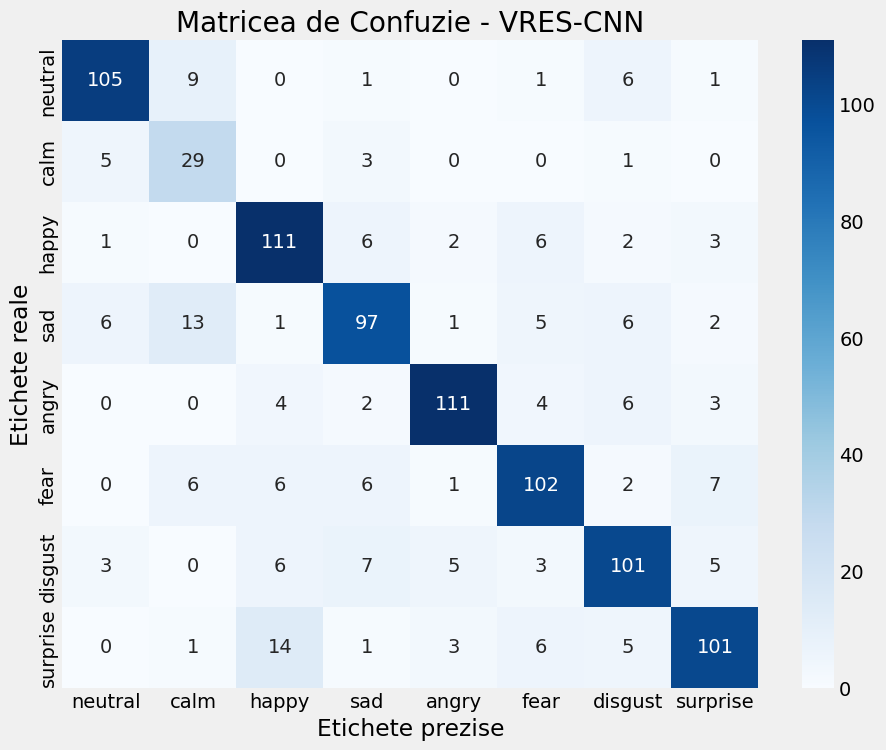

Raport clasificare:

              precision    recall  f1-score   support

     neutral       0.88      0.85      0.86       123
        calm       0.50      0.76      0.60        38
       happy       0.78      0.85      0.81       131
         sad       0.79      0.74      0.76       131
       angry       0.90      0.85      0.88       130
        fear       0.80      0.78      0.79       130
     disgust       0.78      0.78      0.78       130
    surprise       0.83      0.77      0.80       131

    accuracy                           0.80       944
   macro avg       0.78      0.80      0.79       944
weighted avg       0.81      0.80      0.80       944



In [137]:
#MATRICEA DE CONFUZIE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Preziceri pe datele de test
y_pred = vres_cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertim la clase

# Construirea matricei de confuzie
cm = confusion_matrix(y_test, y_pred_classes)

from sklearn.metrics import classification_report

# Etichete pentru cele 8 clase

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']


# Afișare cu seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Matricea de Confuzie - VRES-CNN")
plt.xlabel("Etichete prezise")
plt.ylabel("Etichete reale")
plt.show()
# Afișare scoruri (precizie, recall, f1)
print("Raport clasificare:\n")
print(classification_report(y_test, y_pred_classes, target_names=emotion_labels))
#print(classification_report(y_test, y_pred_classes, target_names=emotion_labels))

In [138]:
# Conversie în TFLite

def convert_to_tflite(model, tflite_name):
    model.export('temp_saved_model', format="tf_saved_model")
    converter = tf.lite.TFLiteConverter.from_saved_model('temp_saved_model')
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(tflite_name, 'wb') as f:
        f.write(tflite_model)
    print(f"\n Conversie realizată: {tflite_name}")


In [139]:
# Evaluare model TFLite

def evaluate_tflite(tflite_path, X_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    correct = 0
    total = X_test.shape[0]

    t1 = ti.time()
    for i in range(total):
        input_data = X_test[i:i+1].astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        if np.argmax(output) == y_test[i]:
            correct += 1
    t2 = ti.time()

    acc = round(100 * correct / total, 2)
    latency = round(1000 * (t2 - t1) / total, 2)
    size = os.path.getsize(tflite_path) // 1024

    print(f"Acuratețe .tflite: {acc}% | Latență: {latency} ms/exemplu | Dimensiune: {size} KB")

    # dictionar( o sa am nev de el mai incolo la comparare intre modele)
    results = {
        'tflite_acc': acc,
        'tflite_latency': latency,
        'tflite_size': size
    }
    return results


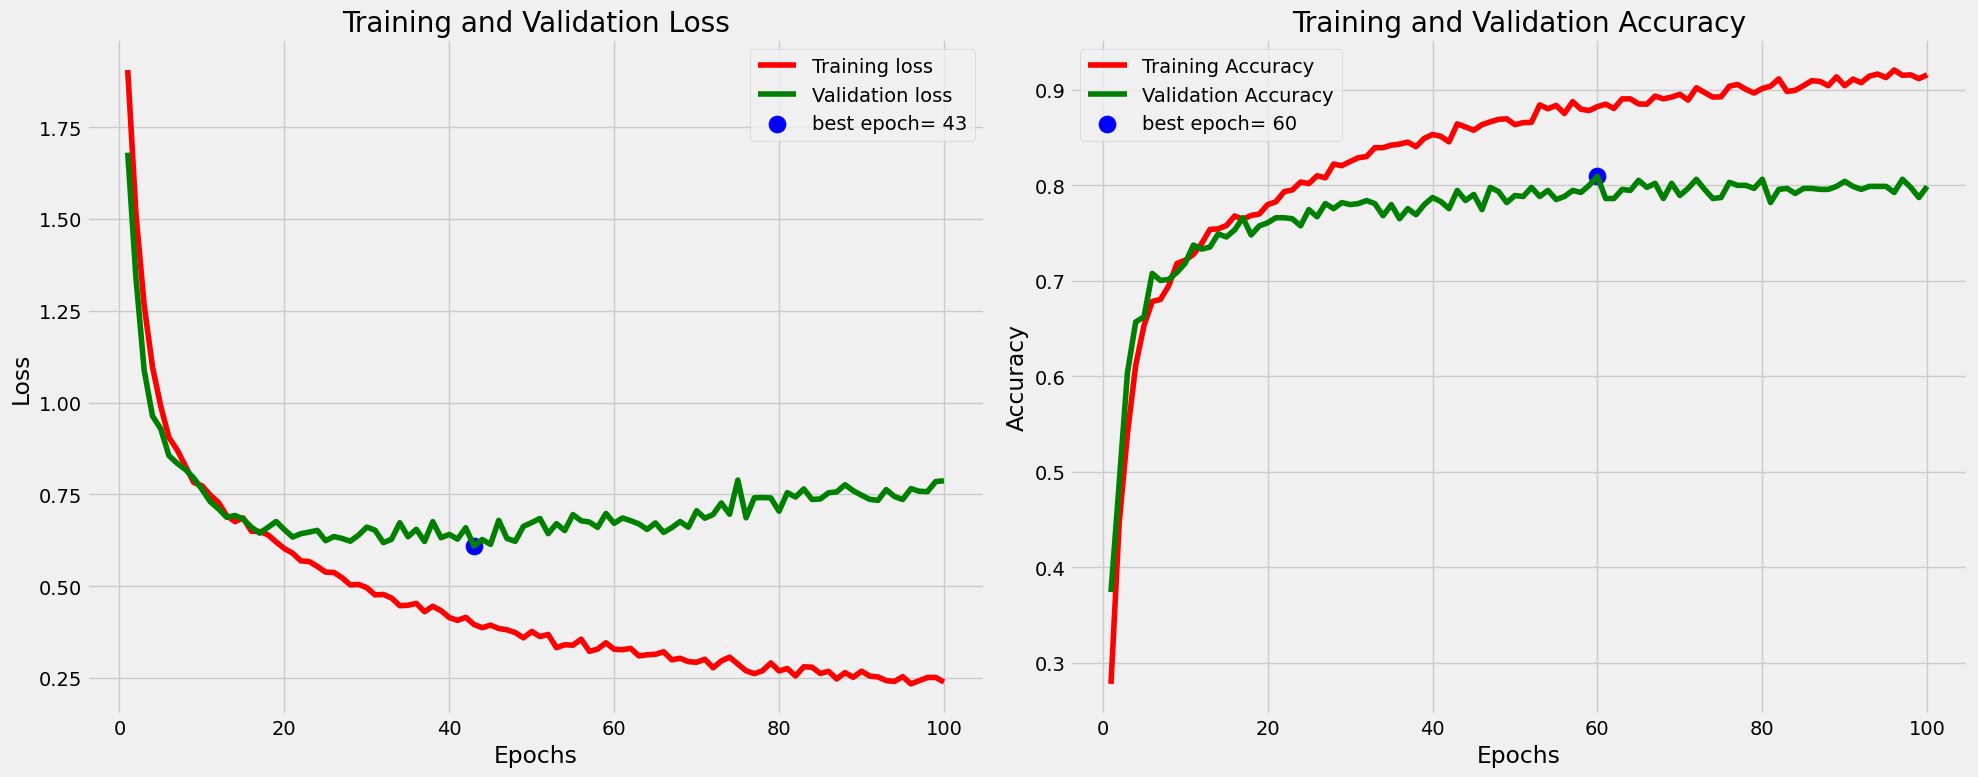

In [140]:
#  Vizualizare progres antrenare
from matplotlib import pyplot as plt
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [154]:
vres_model,vres_results = evaluate_keras_model('best_vres_model.keras', X_test, y_test, history_vres,
                                  "VRES-CNN", macs_vres, dataset, lrate, batch_size, input_shape)
convert_to_tflite(vres_model, 'vres_model.tflite')
vres_tflite_results =evaluate_tflite('vres_model.tflite', X_test, y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 

📊 Raport pentru VRES-CNN
Parametri model: 28.97 K
MACs: 1433.86 K
Cea mai bună acuratețe pe validare: 80.19%
Cea mai bună acuratețe pe antrenare: 91.34%
Acuratețe pe test: 80.19%
Latență per eșantion: 0.96 ms

📄 Rezumat: Device_CPU_VRES-CNN_/kaggle/working/RDT1_Sz|10 Bt|10 Lr|0.001 Ep|100 Kpar|28.97k MAC|1433.86K Vacc|80.19 TrAcc|91.34 TestAcc|80.19 Lat|0.96ms
Saved artifact at 'temp_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 10, 1), dtype=tf.float32, name='input_layer_15')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  139922056878928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139922056874128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139922056872400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139922056878544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139922056887568: TensorSpec(s

W0000 00:00:1745353411.375953      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745353411.375988      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [142]:
#MODEL PT COMPARARE 
#CREARE MODEL V-CNN ( adaptat dupa codul de la curs)

# MODEL V-CNN - Bazat pe structura VRES-CNN (fără conexiuni reziduale și fără separable conv)
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Add, MaxPooling2D, \
                         GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation

# Bloc V-CNN (fără conexiuni reziduale, fără separable conv)
def vcnn_block(x, filters, nl, resid=False, separ=False, myact='hard_silu'):
    csize = 3
    drop1 = 0.3
    pad = 'same'
    stri = 2
    psiz = 2

    if nl > 0:
        y = Conv2D(filters, (csize, csize), padding=pad)(x)
        y = Activation(myact)(y)
        for _ in range(1, nl):
            y = Conv2D(filters, (csize, csize), padding=pad)(y)
            y = Activation(myact)(y)
        y = Conv2D(filters, (csize, csize), padding=pad)(y)
    else:
        y = Conv2D(filters, (csize, csize), padding=pad)(x)

    out = y
    out = BatchNormalization()(out)
    out = MaxPooling2D(pool_size=(psiz, psiz), strides=(stri, stri))(out)
    out = Dropout(drop1)(out)
    return out

# Funcția de creare a modelului V-CNN
def create_vcnn(input_shape, num_classes, myact='relu', flat=0, fil=[10, 40], nl=[2, 1], hid=[], scale=False, lrate=0.001):
    inputs = Input(shape=input_shape)
    x = inputs / 255. if scale else inputs

    for i in range(len(fil)):
        x = vcnn_block(x, fil[i], nl[i], resid=False, separ=False, myact=myact)

    if flat == 1:
        x = Flatten()(x)
    else:
        x = GlobalAveragePooling2D()(x)

    for h in hid:
        x = Dense(h, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model.build(input_shape=(None,) + input_shape)
    return model

# Parametrii pentru comparație corectă cu VRES-CNN
myflat = 0
myfil = [16, 32]
mynl = [2, 2]
myhid = []
myact = 'hard_silu'
myscale = False
lrate = 0.001

# Creare model V-CNN
v_cnn_model = create_vcnn(input_shape, num_classes, myact=myact, flat=myflat,
                          fil=myfil, nl=mynl, hid=myhid, scale=myscale, lrate=lrate)

v_cnn_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 10, 10, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_122 (Conv2D)                  │ (None, 10, 10, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_64 (Activation)           │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_123 (Conv2D)                  │ (None, 10, 10, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_65 (Activation)           │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_124 (Conv2D)                  │ (None, 10, 10, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 10, 10, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_125 (Conv2D)                  │ (None, 5, 5, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_66 (Activation)           │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_126 (Conv2D)                  │ (None, 5, 5, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_67 (Activation)           │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_127 (Conv2D)                  │ (None, 5, 5, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 5, 5, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,392 (110.91 KB)

 Trainable params: 28,296 (110.53 KB)

 Non-trainable params: 96 (384.00 B)

In [143]:
# Antrenarea modelului V-CNN
from keras.callbacks import ModelCheckpoint
import time as ti

checkpoint = ModelCheckpoint('best_vcnn_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
EPOCHS = 100
BATCH_SIZE = 8 #cand e 8 timpul de antrenare e la 2 min si cv dar scade cam 1-2% acuratetea, cand e 4 timpul de antrenare e pe la 4 min si cv, cu acuratete mai buna
t1 = ti.time()

history_vcnn = v_cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    verbose=1
)
t2 = ti.time()

print('Antrenarea cu', EPOCHS, 'epoci a durat', int(t2 - t1) / 60, 'minute')


Epoch 1/100
460/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2444 - loss: 1.9921
Epoch 1: val_accuracy improved from -inf to 0.47881, saving model to best_vcnn_model.keras
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2464 - loss: 1.9874 - val_accuracy: 0.4788 - val_loss: 1.5631
Epoch 2/100
464/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4875 - loss: 1.4494
Epoch 2: val_accuracy improved from 0.47881 to 0.61653, saving model to best_vcnn_model.keras
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4881 - loss: 1.4477 - val_accuracy: 0.6165 - val_loss: 1.0969
Epoch 3/100
464/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5944 - loss: 1.1658
Epoch 3: val_accuracy improved from 0.61653 to 0.68008, saving model to best_vcnn_model.keras
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5946 - loss: 1.1654 - val_accuracy: 0.6801 - val_loss: 0.9660
Epoch 4/100
471/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: 1.0202
Epoch 4: val_accuracy 

In [144]:
#calculez MACs pt vcnn
from keras.models import load_model


vcnn_model = load_model('best_vcnn_model.keras')


macs_vcnn = estimate_macs(vcnn_model)


print(f"V-CNN MACs: {macs_vcnn//1000} K")

conv2d_122: 230400 MACs
conv2d_123: 230400 MACs
conv2d_124: 230400 MACs
conv2d_125: 230400 MACs
conv2d_126: 230400 MACs
conv2d_127: 230400 MACs
dense_17: 256 MACs
V-CNN MACs: 1382 K


In [ ]:
#!!!!!nu mai e nevoie de ea
#e in stand_by
# Încărcare model și evaluare pe test
from keras.models import load_model
model = load_model('best_vcnn_model.keras')

score = model.evaluate(X_test, y_test, verbose=0)
best_val = round(100 * max(history.history['val_accuracy']), 2)
best_tr = round(100 * max(history.history['accuracy']), 2)
best_ts = round(100 * score[1], 2)
print(f"Cea mai bună acuratețe pe validare: {best_val}%")
print(f"Acuratețe pe test: {best_ts}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


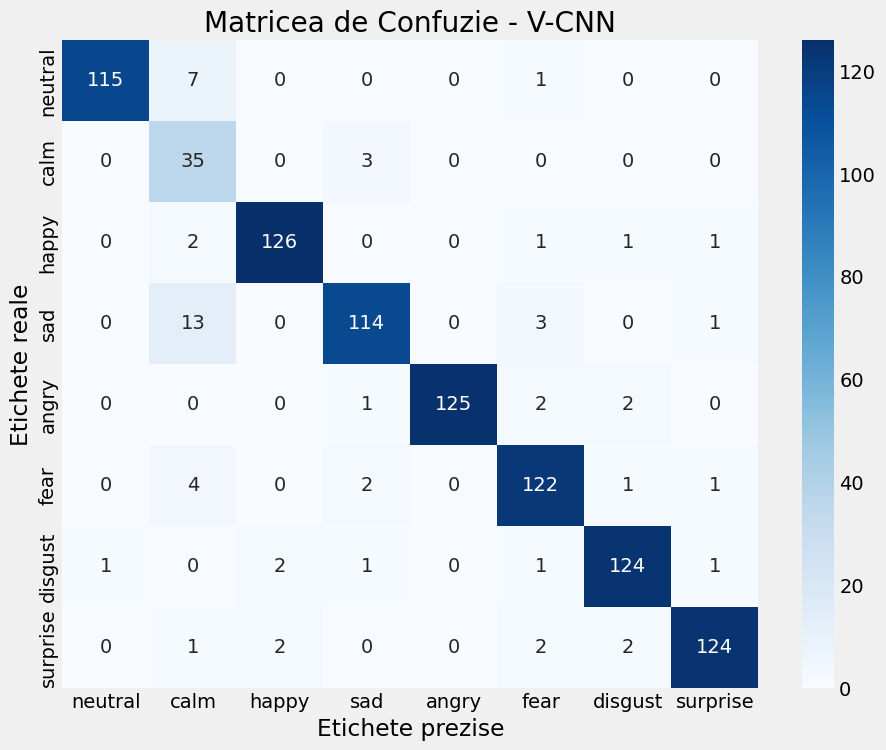

Raport clasificare:

              precision    recall  f1-score   support

     neutral       0.99      0.93      0.96       123
        calm       0.56      0.92      0.70        38
       happy       0.97      0.96      0.97       131
         sad       0.94      0.87      0.90       131
       angry       1.00      0.96      0.98       130
        fear       0.92      0.94      0.93       130
     disgust       0.95      0.95      0.95       130
    surprise       0.97      0.95      0.96       131

    accuracy                           0.94       944
   macro avg       0.91      0.94      0.92       944
weighted avg       0.95      0.94      0.94       944



In [145]:
#Matrice de confuzie pentru V-CNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Preziceri pe datele de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertim la clase

# Construirea matricei de confuzie
cm = confusion_matrix(y_test, y_pred_classes)

from sklearn.metrics import classification_report

# Etichete pentru cele 8 clase

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']


# Afișare cu seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Matricea de Confuzie - V-CNN")
plt.xlabel("Etichete prezise")
plt.ylabel("Etichete reale")
plt.show()
# Afișare scoruri (precizie, recall, f1)
print("Raport clasificare:\n")
print(classification_report(y_test, y_pred_classes, target_names=emotion_labels))

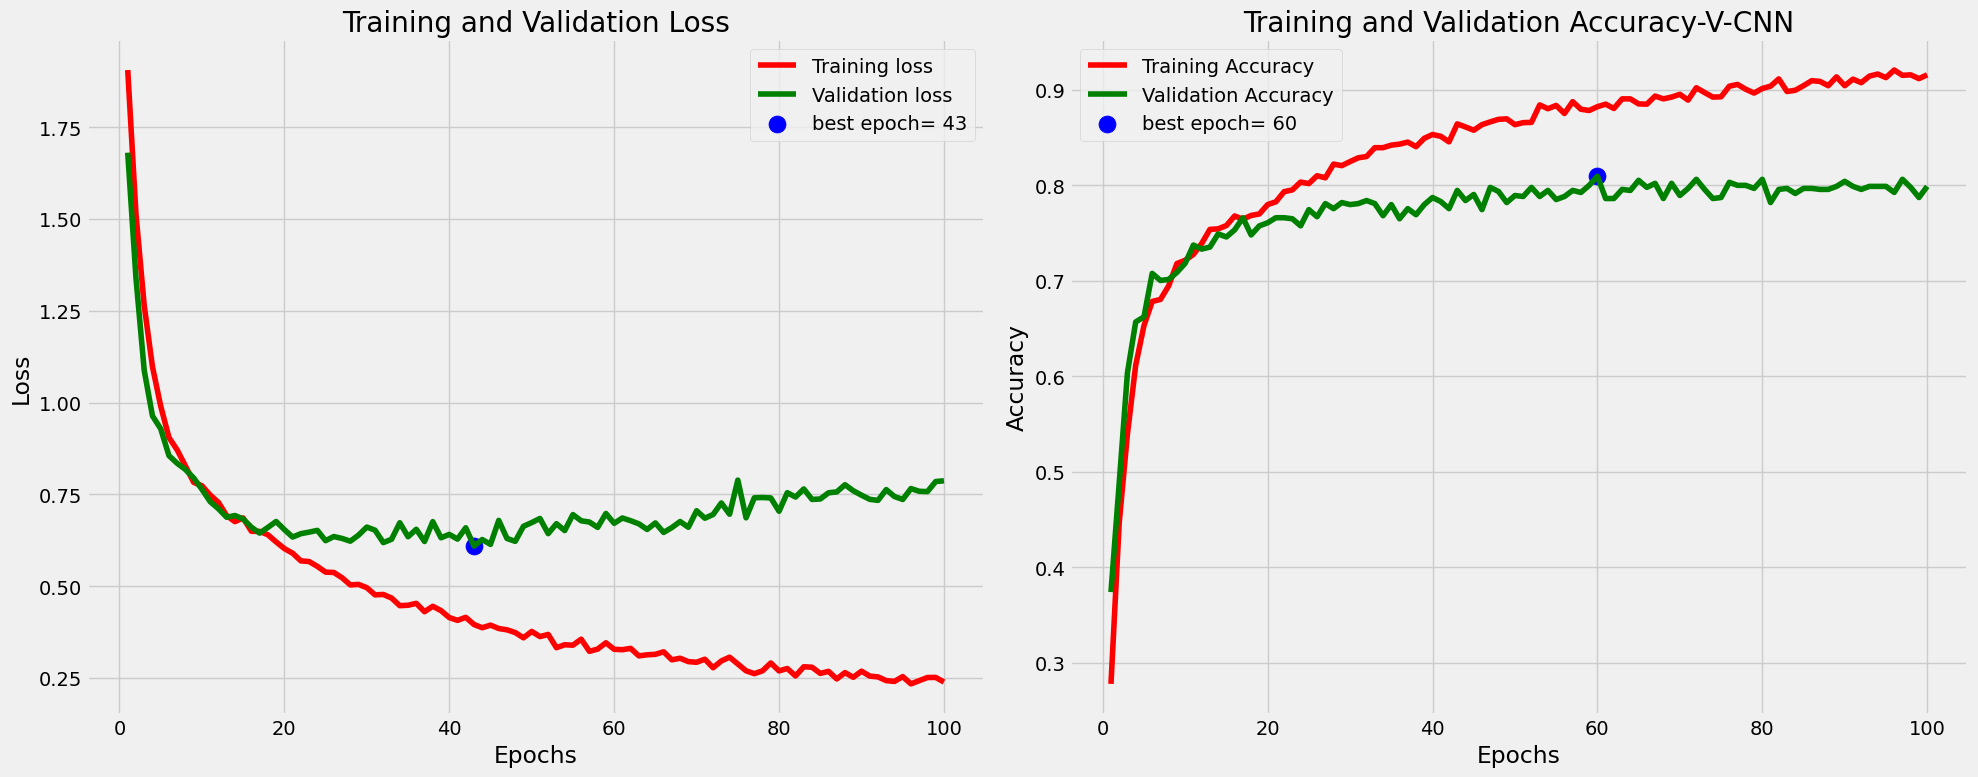

In [146]:
#  Vizualizare progres antrenare pt V-CNN
from matplotlib import pyplot as plt
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy-V-CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [155]:
vcnn_model,vcnn_results = evaluate_keras_model('best_vcnn_model.keras', X_test, y_test, history_vcnn,
                                  "V-CNN", macs_vcnn, dataset, lrate, batch_size, input_shape)
convert_to_tflite(vcnn_model, 'vcnn_model.tflite')
vcnn_tflite_results = evaluate_tflite('vcnn_model.tflite', X_test, y_test)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 

📊 Raport pentru V-CNN
Parametri model: 28.39 K
MACs: 1382.66 K
Cea mai bună acuratețe pe validare: 80.08%
Cea mai bună acuratețe pe antrenare: 90.44%
Acuratețe pe test: 80.08%
Latență per eșantion: 0.86 ms

📄 Rezumat: Device_CPU_V-CNN_/kaggle/working/RDT1_Sz|10 Bt|10 Lr|0.001 Ep|100 Kpar|28.39k MAC|1382.66K Vacc|80.08 TrAcc|90.44 TestAcc|80.08 Lat|0.86ms
Saved artifact at 'temp_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 10, 1), dtype=tf.float32, name='input_layer_16')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  139924499345680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139922056883344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139922056886992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139922056877584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139918900163408: TensorSpec(shape=(

W0000 00:00:1745353491.848026      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745353491.848064      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [156]:
#Tabel de comparatie intre cele 2 modele
data = {
    "Caracteristică": [
        "Parametri (K)", 
        "MACs (K)", 
        "Acuratețe Validare (%)", 
        "Acuratețe Test (%)", 
        "Latență Keras (ms)", 
        "Dimensiune .tflite (KB)", 
        "Acuratețe .tflite (%)", 
        "Latență .tflite (ms)"
    ],
    "VRES-CNN": [ 
        vres_results['params'],
        vres_results['macs'],
        vres_results['val_acc'],
        vres_results['test_acc'],
        vres_results['latency_keras'],
        vres_tflite_results['tflite_size'],
        vres_tflite_results['tflite_acc'],
        vres_tflite_results['tflite_latency']
    ],
    "V-CNN": [
        vcnn_results['params'],
        vcnn_results['macs'],
        vcnn_results['val_acc'],
        vcnn_results['test_acc'],
        vcnn_results['latency_keras'],
        vcnn_tflite_results['tflite_size'],
        vcnn_tflite_results['tflite_acc'],
        vcnn_tflite_results['tflite_latency']
    ]
}

df = pd.DataFrame(data)
display(df)


,Caracteristică,VRES-CNN,V-CNN
0,Parametri (K),28.97,28.39
1,MACs (K),1433.86,1382.66
2,Acuratețe Validare (%),80.19,80.08
3,Acuratețe Test (%),80.19,80.08
4,Latență Keras (ms),0.96,0.86
5,Dimensiune .tflite (KB),40.00,36.00
6,Acuratețe .tflite (%),80.08,80.30
7,Latență .tflite (ms),0.04,0.04


In [157]:
vres_cnn_model = load_model('best_vres_model.keras')
vcnn_cnn_model = load_model('best_vcnn_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

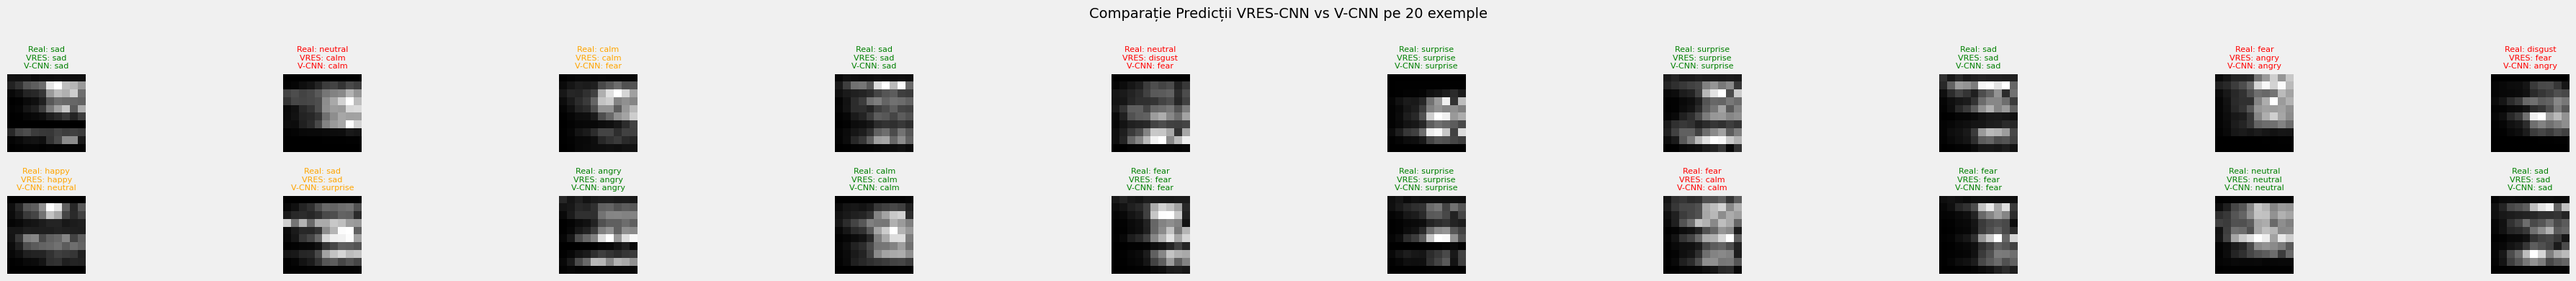


 Statistici pe 20 exemple:
 Corecte la ambele modele: 12
 Greșite de un singur model: 3
 Greșite de ambele modele: 5


In [162]:
import matplotlib.pyplot as plt
import numpy as np

def compara_predictii_versus(vres_model, vcnn_model, X_test, y_test, label_map, num_examples=10):
    idx = np.random.choice(len(X_test), num_examples, replace=False)
    correct_both = 0
    one_wrong = 0
    wrong_both = 0

    plt.figure(figsize=(num_examples * 2, 4))
    for i, index in enumerate(idx):
        img = X_test[index]
        real_label = y_test[index]

        vres_pred = np.argmax(vres_model.predict(img[np.newaxis, ...]))
        vcnn_pred = np.argmax(vcnn_model.predict(img[np.newaxis, ...]))

        # Stabilim culoarea titlului
        if (vres_pred == real_label) and (vcnn_pred == real_label):
            color = 'green'
            correct_both += 1
        elif (vres_pred != real_label) and (vcnn_pred != real_label):
            color = 'red'
            wrong_both += 1
        else:
            color = 'orange'
            one_wrong += 1

        plt.subplot(2, num_examples//2, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f"Real: {label_map[real_label]}\n"
                  f"VRES: {label_map[vres_pred]}\n"
                  f"V-CNN: {label_map[vcnn_pred]}", color=color, fontsize=8)

    plt.suptitle(f"Comparație Predicții VRES-CNN vs V-CNN pe {num_examples} exemple", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Afișare statistică
    print(f"\n Statistici pe {num_examples} exemple:")
    print(f" Corecte la ambele modele: {correct_both}")
    print(f" Greșite de un singur model: {one_wrong}")
    print(f" Greșite de ambele modele: {wrong_both}")

label_map = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}

compara_predictii_versus(vres_cnn_model, vcnn_model, X_test, y_test, label_map, num_examples=20)

